## Donald Trump wordcloud 

Now that that's out of the way... Hi i'm alex (alexanderjcomerford@gmail.com), I like to do data science,
it's pretty cool the stuff that you can do with it. The answers you can find will most of the time surprise you,
but maybe more importantly it's about the questions you should ask!

## 1. The data

Luckily a very kind soul Brendan Brown @bpb27 github has made a [repo](https://github.com/bpb27/trump_tweet_data_archive) where we can immediately download the entire history of his tweets. In the following cells we are going to extract the data into an alternative format to easierly create wordclouds

Here we are going to clone the data from github into our current directory

In [ ]:
github_link = "https://github.com/bpb27/trump_tweet_data_archive"
!git clone {github_link}

Here we unzip the data into `.json` files

In [ ]:
import os
import zipfile

## get zipped files in path
path = "./trump_tweet_data_archive/"
condensed_zip_files = [zip_file 
                       for zip_file in os.listdir(path) 
                       if zip_file.endswith(".zip") and zip_file.startswith("condensed")]

## unzip files
for condensed_zip_file in condensed_zip_files:
    with zipfile.ZipFile(os.path.join(path, condensed_zip_file), "r") as zip_ref:
        zip_ref.extractall(path)

Now to make them usable in this python environment we are going to load each `.json` into a dictionary. Sorry about the impossible to understand list comprehension

In [ ]:
import json

## get json files in path
json_files = [json_file 
              for json_file in os.listdir(path)
              if json_file.endswith(".json")]

## import into dictionary
data = dict((json_file,
             json.load(open(os.path.join(path,json_file)))) 
            for json_file in json_files)

### 2. Pre Processing

Here we are going to filter and process the tweets so we can get a single array of words.

The first pre processing step will be to create a huge array of tweets. This dataset is small so we don't need to worry about parallelization... yet

In [ ]:
import numpy as np
all_tweets = np.concatenate(np.array([data for data_file, data in data.items()])).ravel()

Let's print a random tweet out to see what data we're dealing with

In [ ]:
from random import randint

print ("Collected %d tweets"%all_tweets.shape[0])
print ("Sample\n%s"%all_tweets[randint(0, all_tweets.shape[0])])

Now lets get all of the words from the tweets `"text"` property into a single array

In [ ]:
all_tweets_text = np.vectorize(lambda t:t["text"])(all_tweets)

We are so close! This next step is important because it cleans up our data to give us something consistent and clean to work with. Compared to alot of other tweets, Donald Trumps tweets are very clean so we only really need to be able to filter simple words such as emojis, stopwords, etc.

<b>Important filter:</b>

Donald trump sometimes puts `--` in his tweets so are going to put an additional filter which split parses words that have that symbol inside of it

In [287]:
## pre process sentence 
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)

def custom_filter(word, splitter):
    if splitter in word:
        return word.split(splitter)
    return [word]
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    tokens = np.concatenate(np.array([custom_filter(word, "--") for word in tokens])).ravel()
    tokens = np.concatenate(np.array([custom_filter(word, " ") for word in tokens])).ravel()
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens 

Now that our pre processing functions are defined, let's get all the words

In [288]:
all_tweets_words = np.concatenate(np.array([preprocess(tweet_text) for tweet_text in all_tweets_text])).ravel()

print ("%d words total"%len(all_tweets_words))

690944 words total


Now for some final data cleaning then we will be good to go!

In [289]:
import string
printable = set(string.printable)
text = "".join([word for word in all_tweets_words if set(str(word)) < set(string.printable)])

## Final cleanup because preprocessers not smart enough to get rid of these 
text = text.replace("https", "")
text = text.replace("co", "")

Wow! that's alot of words!!

Now it's time to do the fun part, word clouds!

First we are going to pip install wordloud

In [ ]:
!conda install -c https://conda.anaconda.org/amueller wordcloud -y

Now for the final portion, generate a wordcloud. In this image I have some pictures of trump you can use for you word cloud creating pleasure

Edit `mask_image_path` to add your own custom mask!

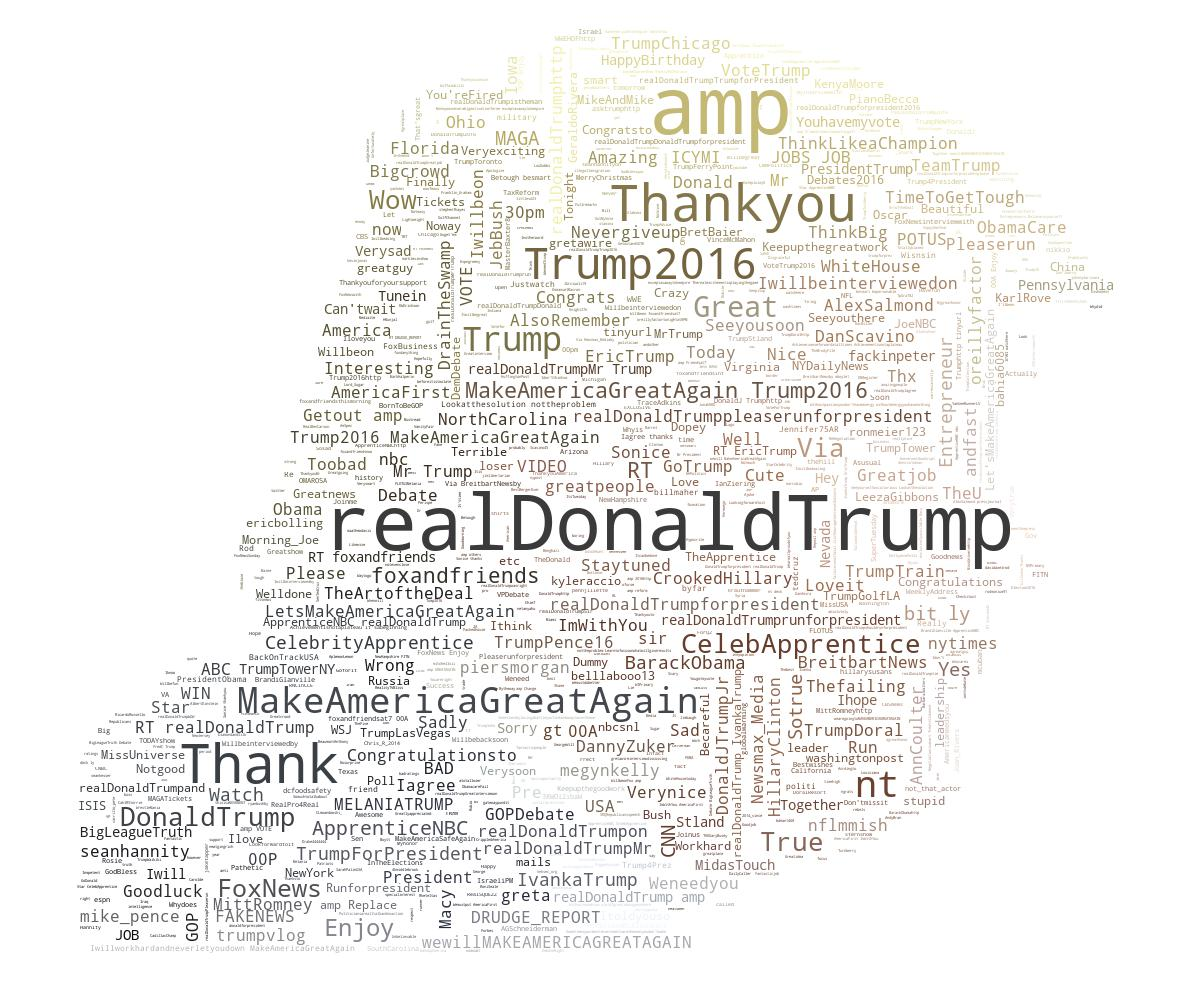

In [319]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

mask_image_path = "./trump_side_cropped.png"

trump_coloring = np.array(Image.open(mask_image_path, 'r'))

wc = WordCloud(background_color="white",
               max_words=1000, 
               mask=trump_coloring,
               stopwords=set(STOPWORDS), 
               max_font_size=80, 
               random_state=42,
               width=800,
               height=800)
# generate word cloud
wc.generate(text)

wc.recolor(color_func=ImageColorGenerator(trump_coloring)).to_file("trump_cloud.jpg")
from IPython.display import Image
Image("trump_cloud.jpg")